# Neural Network Second Attempt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv('coaster_db_clean.csv')
df.head()

2025-10-18 21:57:20.353615: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Unnamed: 0,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Trains,Designer,year_introduced,...,Inversions_clean,Gforce_clean,Length_ft,Height_restriction_in,Cost_USD,Acceleration_clean,Max_vertical_angle,Duration_seconds,Capacity_riders_per_hour,Drop_ft
0,0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,Unknown,LaMarcus Adna Thompson,1884,...,0,2.9,600.0,48.0,8540000.0,9.1,30.0,60.0,1600,43.0
1,1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,Unknown,Unknown,a single car. Riders are arranged 1 across in ...,Lina Beecher,1895,...,1,12.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
2,3,Loop the Loop (Coney Island),Other,Removed,Edwin Prescott,Unknown,Unknown,a single car. Riders are arranged 2 across in ...,Edward A. Green,1901,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
3,4,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,Unknown,Unknown,Unknown,Edward A. Green,1901,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
4,5,Cannon Coaster,Coney Island,Removed,George Francis Meyer,Unknown,Unknown,Unknown,Unknown,1902,...,0,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1028 non-null   int64  
 1   coaster_name              1028 non-null   object 
 2   Location                  1028 non-null   object 
 3   Status                    1028 non-null   object 
 4   Manufacturer              1028 non-null   object 
 5   Model                     1028 non-null   object 
 6   Lift/launch system        1028 non-null   object 
 7   Trains                    1028 non-null   object 
 8   Designer                  1028 non-null   object 
 9   year_introduced           1028 non-null   int64  
 10  latitude                  1028 non-null   float64
 11  longitude                 1028 non-null   float64
 12  track_type                1028 non-null   object 
 13  opening_date_clean        1028 non-null   object 
 14  speed_mp

In [3]:
df = df.drop(df.columns[0], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coaster_name              1028 non-null   object 
 1   Location                  1028 non-null   object 
 2   Status                    1028 non-null   object 
 3   Manufacturer              1028 non-null   object 
 4   Model                     1028 non-null   object 
 5   Lift/launch system        1028 non-null   object 
 6   Trains                    1028 non-null   object 
 7   Designer                  1028 non-null   object 
 8   year_introduced           1028 non-null   int64  
 9   latitude                  1028 non-null   float64
 10  longitude                 1028 non-null   float64
 11  track_type                1028 non-null   object 
 12  opening_date_clean        1028 non-null   object 
 13  speed_mph                 1028 non-null   float64
 14  height_f

In [4]:
# Features and target
X = df.drop(columns=['track_type'])
y = df['track_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# numeric and categorical feature lists
numeric_features = ['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude']
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [5]:
model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
X_train_prep = X_train_prep.toarray()
X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6990 - loss: 0.9135 - val_accuracy: 0.7879 - val_loss: 0.5737
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8071 - loss: 0.5027 - val_accuracy: 0.7879 - val_loss: 0.4728
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8148 - loss: 0.3666 - val_accuracy: 0.8242 - val_loss: 0.3975
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8981 - loss: 0.2887 - val_accuracy: 0.8848 - val_loss: 0.3279
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9438 - loss: 0.1886 - val_accuracy: 0.9152 - val_loss: 0.2896
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9490 - loss: 0.1381 - val_accuracy: 0.9212 - val_loss: 0.2853
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.0745 - val_accuracy: 0.9273 - val_loss: 0.2709
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9721 - loss: 0.0546 - val_accuracy: 0.9333 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test Accuracy: 0.9466

Classification Report:
              precision    recall  f1-score   support

       Other       0.56      0.71      0.62         7
       Steel       0.98      0.96      0.97       163
        Wood       0.92      0.92      0.92        36

    accuracy                           0.95       206
   macro avg       0.82      0.86      0.84       206
weighted avg       0.95      0.95      0.95       206



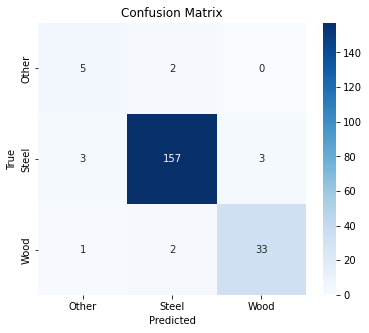

In [6]:
# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

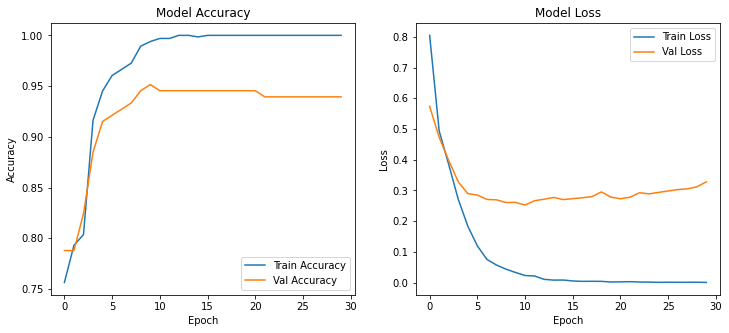

In [7]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [8]:
df = pd.read_csv('coaster_db_clean.csv')
df = df.drop(df.columns[0], axis=1)
len(df[df['track_type'] == 'Steel'])

814

In [9]:
len(df[df['track_type'] == 'Wood'])

177

In [10]:
len(df[df['track_type'] == 'Other'])

37

In [11]:
num_rows_to_remove = 600

# 1. Identify the target rows
target_df = df[df['track_type'] == 'Steel']

# 2. Randomly sample from target rows
# Ensure that num_rows_to_remove does not exceed the number of available target rows
if num_rows_to_remove > len(target_df):
    print(f"Warning: Cannot remove {num_rows_to_remove} rows. Only {len(target_df)} rows with '{target_value}' in '{column_name}' exist.")
    num_rows_to_remove = len(target_df) # Adjust to remove all available rows

rows_to_drop_indices = target_df.sample(n=num_rows_to_remove, random_state=42).index # random_state for reproducibility

# 3. Drop the sampled rows
df = df.drop(rows_to_drop_indices)

print("\nDataFrame after removing random rows:")
df.head()


DataFrame after removing random rows:


,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Trains,Designer,year_introduced,latitude,...,Inversions_clean,Gforce_clean,Length_ft,Height_restriction_in,Cost_USD,Acceleration_clean,Max_vertical_angle,Duration_seconds,Capacity_riders_per_hour,Drop_ft
0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,Unknown,LaMarcus Adna Thompson,1884,40.5740,...,0,2.9,600.0,48.0,8540000.0,9.1,30.0,60.0,1600,43.0
1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,Unknown,Unknown,a single car. Riders are arranged 1 across in ...,Lina Beecher,1895,40.5780,...,1,12.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
3,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,Unknown,Unknown,Unknown,Edward A. Green,1901,39.3538,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
4,Cannon Coaster,Coney Island,Removed,George Francis Meyer,Unknown,Unknown,Unknown,Unknown,1902,40.5750,...,0,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
5,Leap-The-Dips,Lakemont Park,Operating,Federal Construction Company,Unknown,Unknown,Unknown,Edward Joy Morris,1902,40.2864,...,0,4.0,1452.0,48.0,8540000.0,9.1,25.0,60.0,1080,9.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 1025
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coaster_name              428 non-null    object 
 1   Location                  428 non-null    object 
 2   Status                    428 non-null    object 
 3   Manufacturer              428 non-null    object 
 4   Model                     428 non-null    object 
 5   Lift/launch system        428 non-null    object 
 6   Trains                    428 non-null    object 
 7   Designer                  428 non-null    object 
 8   year_introduced           428 non-null    int64  
 9   latitude                  428 non-null    float64
 10  longitude                 428 non-null    float64
 11  track_type                428 non-null    object 
 12  opening_date_clean        428 non-null    object 
 13  speed_mph                 428 non-null    float64
 14  height_ft

In [13]:
# Features and target
X = df.drop(columns=['track_type'])
y = df['track_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# numeric and categorical feature lists
numeric_features = ['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude']
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [14]:
model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
X_train_prep = X_train_prep.toarray()
X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3049 - loss: 1.1402 - val_accuracy: 0.6812 - val_loss: 0.9825
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6630 - loss: 0.9511 - val_accuracy: 0.7391 - val_loss: 0.8572
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7435 - loss: 0.8451 - val_accuracy: 0.8116 - val_loss: 0.7444
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8023 - loss: 0.7229 - val_accuracy: 0.8696 - val_loss: 0.6223
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8199 - loss: 0.5909 - val_accuracy: 0.8696 - val_loss: 0.5025
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8747 - loss: 0.4218 - val_accuracy: 0.8696 - val_loss: 0.4119
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9031 - loss: 0.3364 - val_accuracy: 0.8696 - val_loss: 0.3556
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8898 - loss: 0.2889 - val_accuracy: 0.8696 - val_loss: 0.3191
Epoch 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test Accuracy: 0.8372

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      0.43      0.60         7
       Steel       0.77      0.95      0.85        43
        Wood       0.93      0.78      0.85        36

    accuracy                           0.84        86
   macro avg       0.90      0.72      0.77        86
weighted avg       0.86      0.84      0.83        86



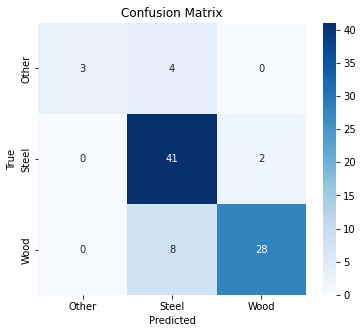

In [15]:
# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

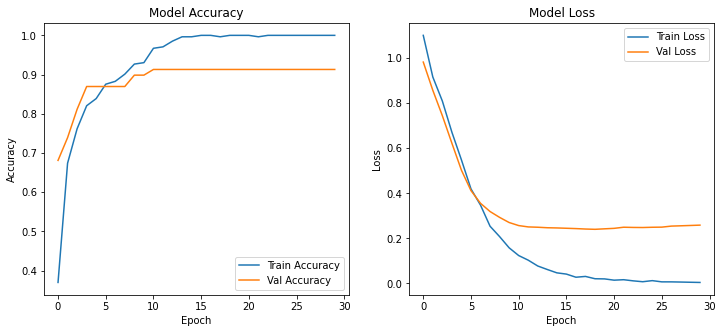

In [16]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()